# PyTorch Neural Network Classification (circules, Binary classification)

In [1]:
import numpy as np
import pandas as pd
# Standard PyTorch imports
import torch
from torch import nn

from sklearn.datasets import make_circles

import matplotlib.pyplot as plt

# Split data into train and test sets
from sklearn.model_selection import train_test_split

# параметры вывода
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.precision',7)
pd.options.display.float_format = '{:.5f}'.format

# выключаем ненужные предупреждения
import warnings 
warnings.filterwarnings('ignore') 

/Users/marinalysenko/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
################         Plot functions block           #####################


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [3]:
################        Create an evaluation metric       ################
#Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [4]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Step 1. Make classification data

In [5]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [6]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75  0.23]
 [-0.76  0.15]
 [-0.82  0.17]
 [-0.39  0.69]
 [ 0.44 -0.9 ]]

First 5 y labels:
[1 1 1 1 0]


In [7]:
# Make DataFrame of circle data

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.75425,0.23148,1
1,-0.75616,0.15326,1
2,-0.81539,0.17328,1
3,-0.39373,0.69288,1
4,0.44221,-0.89672,0
5,-0.47965,0.67643,1
6,-0.01365,0.80335,1
7,0.77151,0.14776,1
8,-0.16932,-0.79346,1
9,-0.12149,1.02151,0


In [8]:
# Check different labels
circles.label.value_counts()

0    500
1    500
Name: label, dtype: int64

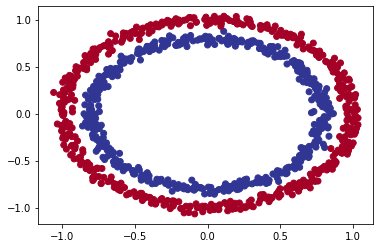

In [9]:
# Visualize with a plot
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations with result in errors in your models.


In [10]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75 0.23] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

Specifically, we'll need to:
1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [12]:
# Turn data into tensors
# Otherwise this causes issues with computations later on

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

##  Building a base model (from lesson demo, 79.00%)

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.

## Create and fit model with non-linearity 



In [14]:
# Build model with non-linear activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [15]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [16]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

 

# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accs = []

test_losses = []
test_accs = []


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    train_losses.append(loss.item())    
    train_accs.append(acc)
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
      test_losses.append(loss.item()) 
      test_accs.append(test_acc)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69859, Accuracy: 50.00% | Test Loss: 0.69819, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69210, Accuracy: 49.88% | Test Loss: 0.69278, Test Accuracy: 49.00%
Epoch: 200 | Loss: 0.68911, Accuracy: 51.88% | Test Loss: 0.69067, Test Accuracy: 51.50%
Epoch: 300 | Loss: 0.68558, Accuracy: 54.62% | Test Loss: 0.68812, Test Accuracy: 51.50%
Epoch: 400 | Loss: 0.68000, Accuracy: 55.88% | Test Loss: 0.68392, Test Accuracy: 51.50%
Epoch: 500 | Loss: 0.67050, Accuracy: 59.13% | Test Loss: 0.67639, Test Accuracy: 57.50%
Epoch: 600 | Loss: 0.65313, Accuracy: 68.25% | Test Loss: 0.66133, Test Accuracy: 65.50%
Epoch: 700 | Loss: 0.61627, Accuracy: 89.50% | Test Loss: 0.62700, Test Accuracy: 87.50%
Epoch: 800 | Loss: 0.53677, Accuracy: 98.75% | Test Loss: 0.55717, Test Accuracy: 97.50%
Epoch: 900 | Loss: 0.39986, Accuracy: 99.88% | Test Loss: 0.43175, Test Accuracy: 98.00%


Text(0, 0.5, 'Loss')

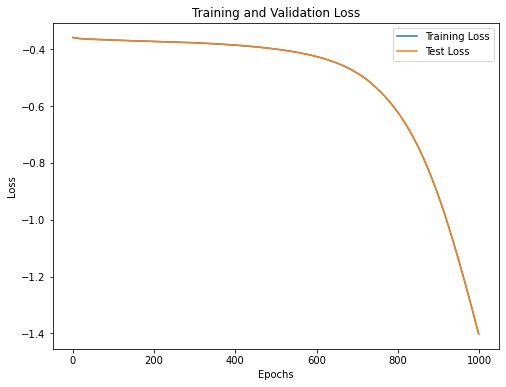

In [17]:
# Plot and label the training and validation loss values
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(epochs), np.log(train_losses), label='Training Loss')
plt.plot(range(epochs), np.log(test_losses), label='Test Loss')

ax.legend(loc="best")

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Accuracy by epoch')

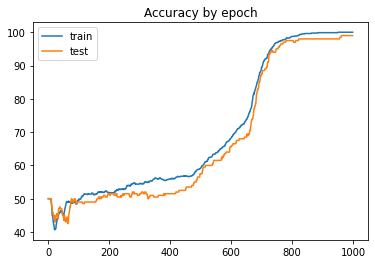

In [18]:
# Plot accuracy
plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.title("Accuracy by epoch")

### Evaluating a model trained with non-linear activation functions


In [19]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

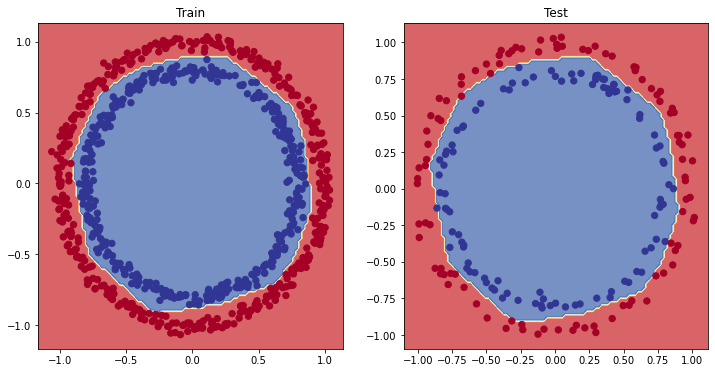

In [20]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)  
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  

## Experiment 1 model (SELU - 89,5%)

In [21]:
# Build model with non-linear activation function

class CircleModel_exp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.SELU() 

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModel_exp1().to(device)
print(model)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accs = []

test_losses = []
test_accs = []


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    train_losses.append(loss.item())    
    train_accs.append(acc)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
      test_losses.append(loss.item()) 
      test_accs.append(test_acc)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

CircleModel_exp1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): SELU()
)
Epoch: 0 | Loss: 0.69273, Accuracy: 53.62% | Test Loss: 0.69007, Test Accuracy: 51.50%
Epoch: 100 | Loss: 0.68909, Accuracy: 54.12% | Test Loss: 0.68936, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.68706, Accuracy: 64.00% | Test Loss: 0.68752, Test Accuracy: 63.50%
Epoch: 300 | Loss: 0.68416, Accuracy: 65.00% | Test Loss: 0.68464, Test Accuracy: 62.00%
Epoch: 400 | Loss: 0.67937, Accuracy: 68.38% | Test Loss: 0.68027, Test Accuracy: 64.50%
Epoch: 500 | Loss: 0.67265, Accuracy: 72.38% | Test Loss: 0.67446, Test Accuracy: 64.50%
Epoch: 600 | Loss: 0.66383, Accuracy: 74.88% | Test Loss: 0.66657, Test Accuracy: 69.00%
Epoch: 700 | Loss: 0.65026, Accuracy: 77.75% | Test Loss: 0.65483, Test Accuracy: 71.50%
Epoch: 800 | Loss: 0.62715, Accuracy: 82.62% | Test Loss: 0.635

Text(0, 0.5, 'Loss')

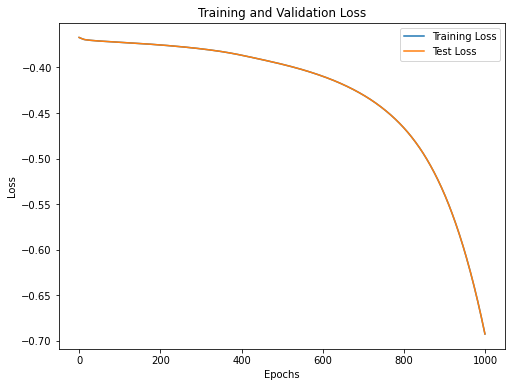

In [22]:
 # Plot and label the training and validation loss values
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(epochs), np.log(train_losses), label='Training Loss')
plt.plot(range(epochs), np.log(test_losses), label='Test Loss')

ax.legend(loc="best")

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Accuracy by epoch')

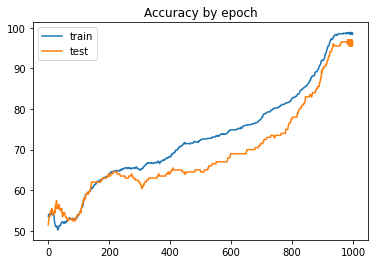

In [23]:
# Plot accuracy
plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.title("Accuracy by epoch")

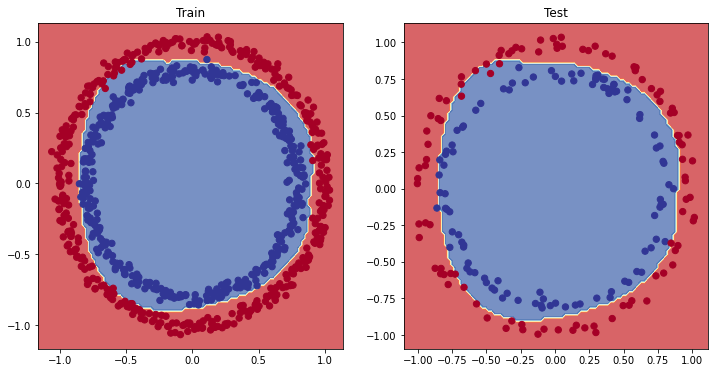

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)  
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 

## Experiment 2 model (SELU, Adagrad - 89,5%)

In [25]:
# Build model with non-linear activation function

class CircleModel_exp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.SELU() 

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModel_exp1().to(device)
print(model)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000



# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accs = []

test_losses = []
test_accs = []


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    train_losses.append(loss.item())    
    train_accs.append(acc)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
      test_losses.append(loss.item()) 
      test_accs.append(test_acc)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

CircleModel_exp1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): SELU()
)
Epoch: 0 | Loss: 0.69273, Accuracy: 53.62% | Test Loss: 0.86816, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.33866, Accuracy: 91.25% | Test Loss: 0.36487, Test Accuracy: 89.50%
Epoch: 200 | Loss: 0.11413, Accuracy: 99.75% | Test Loss: 0.14641, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.04874, Accuracy: 99.88% | Test Loss: 0.07405, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.02837, Accuracy: 100.00% | Test Loss: 0.04863, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.01940, Accuracy: 100.00% | Test Loss: 0.03698, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.01456, Accuracy: 100.00% | Test Loss: 0.03039, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.01158, Accuracy: 100.00% | Test Loss: 0.02615, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00955, Accuracy: 100.00% | Test 

Text(0, 0.5, 'Loss')

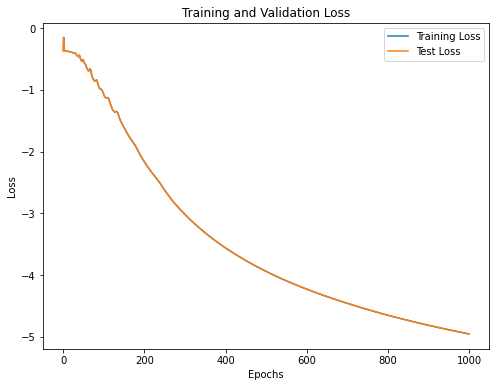

In [26]:
 # Plot and label the training and validation loss values
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(epochs), np.log(train_losses), label='Training Loss')
plt.plot(range(epochs), np.log(test_losses), label='Test Loss')

ax.legend(loc="best")

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Accuracy by epoch')

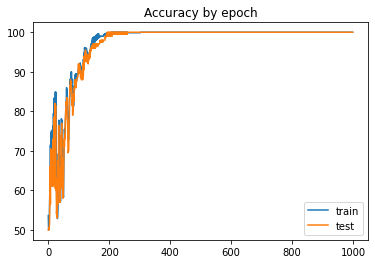

In [27]:
# Plot accuracy
plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.title("Accuracy by epoch")

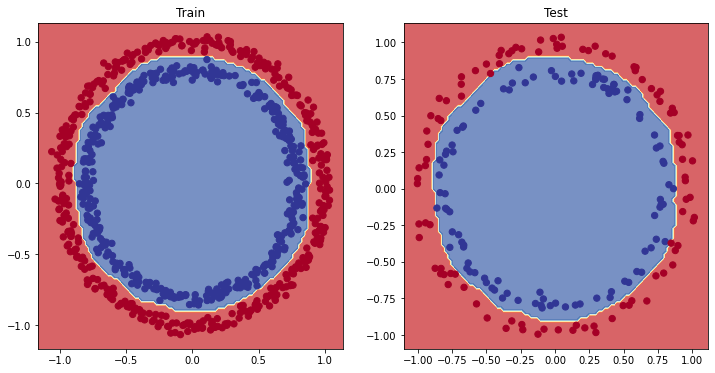

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)  
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 151


## Experiment 3 model - less layers

In [30]:
class CircleModel_exp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.SELU() 

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_2(self.relu(self.layer_1(x)))

model = CircleModel_exp1().to(device)
print(model)

CircleModel_exp1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
  (relu): SELU()
)


In [31]:

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000



# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accs = []

test_losses = []
test_accs = []


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    train_losses.append(loss.item())    
    train_accs.append(acc)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
      test_losses.append(loss.item()) 
      test_accs.append(test_acc)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70657, Accuracy: 47.88% | Test Loss: 0.71891, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.56005, Accuracy: 84.00% | Test Loss: 0.55644, Test Accuracy: 87.00%
Epoch: 200 | Loss: 0.36369, Accuracy: 97.12% | Test Loss: 0.37988, Test Accuracy: 96.00%
Epoch: 300 | Loss: 0.25656, Accuracy: 98.75% | Test Loss: 0.28402, Test Accuracy: 97.00%
Epoch: 400 | Loss: 0.19754, Accuracy: 99.25% | Test Loss: 0.22714, Test Accuracy: 97.50%
Epoch: 500 | Loss: 0.16043, Accuracy: 99.38% | Test Loss: 0.19273, Test Accuracy: 97.50%
Epoch: 600 | Loss: 0.13628, Accuracy: 99.12% | Test Loss: 0.17024, Test Accuracy: 97.50%
Epoch: 700 | Loss: 0.11939, Accuracy: 99.12% | Test Loss: 0.15500, Test Accuracy: 97.50%
Epoch: 800 | Loss: 0.10614, Accuracy: 99.25% | Test Loss: 0.14317, Test Accuracy: 98.00%
Epoch: 900 | Loss: 0.09528, Accuracy: 99.25% | Test Loss: 0.13296, Test Accuracy: 98.00%


Text(0, 0.5, 'Loss')

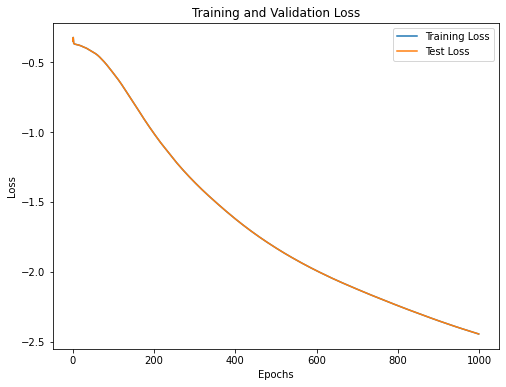

In [32]:
 # Plot and label the training and validation loss values
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(epochs), np.log(train_losses), label='Training Loss')
plt.plot(range(epochs), np.log(test_losses), label='Test Loss')

ax.legend(loc="best")

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

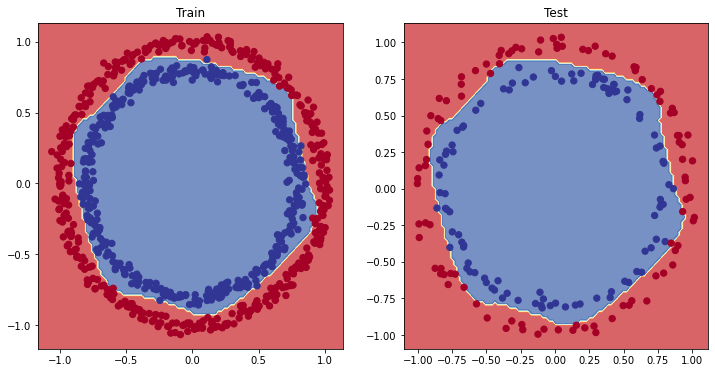

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)  
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 

In [34]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 41


## Experiment 4 model - reduce the number of neurons in the hidden layer

In [35]:
class CircleModel_exp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=7)
        self.layer_2 = nn.Linear(in_features=7, out_features=1)
        self.relu = nn.SELU() 

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_2(self.relu(self.layer_1(x)))

model = CircleModel_exp1().to(device)
print(model)

CircleModel_exp1(
  (layer_1): Linear(in_features=2, out_features=7, bias=True)
  (layer_2): Linear(in_features=7, out_features=1, bias=True)
  (relu): SELU()
)


In [36]:

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 1000



# Initialize lists to store loss and accuracy values for each epoch
train_losses = []
train_accs = []

test_losses = []
test_accs = []


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    train_losses.append(loss.item())    
    train_accs.append(acc)
    
    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
      test_losses.append(loss.item()) 
      test_accs.append(test_acc)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71364, Accuracy: 53.12% | Test Loss: 0.69486, Test Accuracy: 52.50%
Epoch: 100 | Loss: 0.52056, Accuracy: 91.50% | Test Loss: 0.54580, Test Accuracy: 87.00%
Epoch: 200 | Loss: 0.35481, Accuracy: 95.88% | Test Loss: 0.39271, Test Accuracy: 96.00%
Epoch: 300 | Loss: 0.27582, Accuracy: 97.00% | Test Loss: 0.31622, Test Accuracy: 95.50%
Epoch: 400 | Loss: 0.23088, Accuracy: 97.50% | Test Loss: 0.26924, Test Accuracy: 95.50%
Epoch: 500 | Loss: 0.20157, Accuracy: 97.38% | Test Loss: 0.24139, Test Accuracy: 95.50%
Epoch: 600 | Loss: 0.17997, Accuracy: 97.75% | Test Loss: 0.21772, Test Accuracy: 96.50%
Epoch: 700 | Loss: 0.16425, Accuracy: 97.50% | Test Loss: 0.20503, Test Accuracy: 95.50%
Epoch: 800 | Loss: 0.15190, Accuracy: 97.50% | Test Loss: 0.19171, Test Accuracy: 96.50%
Epoch: 900 | Loss: 0.14173, Accuracy: 97.50% | Test Loss: 0.18204, Test Accuracy: 96.50%


Text(0, 0.5, 'Loss')

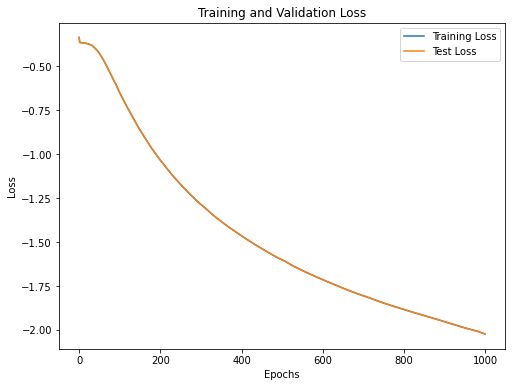

In [37]:
 # Plot and label the training and validation loss values
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(epochs), np.log(train_losses), label='Training Loss')
plt.plot(range(epochs), np.log(test_losses), label='Test Loss')

ax.legend(loc="best")

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

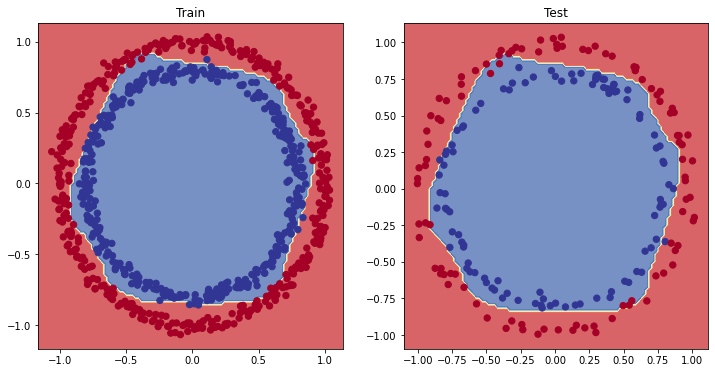

In [38]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)  
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) 

In [39]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 29


### Сокращено количество параетров до 29 и получена целевая точность